In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib
import gc

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=2):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

In [5]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisibleSurface(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    surface_coord3D = np.zeros([3,4])
    visible_flag = np.zeros(4)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        surface_coord3D[:,i] = c_plane
        if np.dot(c_to_O, normal)>0:
            visible_flag[i] = 1
    return visible_flag==1, surface_coord3D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    # 直方体の各頂点のxyz座標を計算
    face_idx = np.array([[0,1,5,4], # front face
                         [1,2,6,5], # right face
                         [2,3,7,6], # back face
                         [3,0,4,7]]) # left face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz
    
    # 直方体の各頂点が見えているかどうかを判定
    visible_corner_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner_coord2D = projectToImage(corner3D, P) # 画像座標に変換
    
    # 直方体の面の座標、面が見えているかどうかを判定
    visible_surface_flag, surface_coord3D = selectVisibleSurface(corner3D)
    surface_coord2D = projectToImage(surface_coord3D, P)
    
    if xyz[2]<0.1:
        return []
    else:
        return visible_corner_flag, corner_coord2D, visible_surface_flag, surface_coord2D

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

In [6]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img, training=False):
    #scale, aspect racioを変更
    scale = rand()*.3+1.5
    aspect_ratio = rand()*0.15
    fx = scale/RESIZE_SCALE*(1+aspect_ratio)
    fy = scale/RESIZE_SCALE
    resized_img = cv2.resize(img, dsize=None, fx=fx, fy=fy)
    assert np.max(img)<=1, "image data is not scaled within 0~1"
    
    #img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    if training:
        img_shape = resized_img.shape[0], resized_img.shape[1]
        off_x = randint(0, img_shape[1]-IMG_WIDTH)
        off_y = randint(0, img_shape[0]-IMG_HEIGHT)
    else:
        off_x = np.round((IMG_WIDTH-img_shape[1])/2).astype('int')
        off_y = np.round((IMG_HEIGHT-img_shape[0])/2).astype('int')
    
    #img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    #resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    #img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    
    img_dummy = resized_img[off_y:off_y+IMG_HEIGHT,off_x:off_x+IMG_WIDTH]
    return img_dummy.astype('float32'), (off_x, off_y), (fx, fy)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0), scale=(1,1)):
    
    ## mask data
    # idx 0 : vehicle
    # idx 1 : front and rear side
    # idx 2 : right and left side
    # idx 3 : 3D corner
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 4], dtype='float32')
    ## size of the vehicle : width, height
    regr_size = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    ## offset for 3D detection
    # idx 0,10 : offset from vehicle center to front or rear surface | x, y
    # idx 1,11 : offset from vehicle center to right or left surface | x, y
    # idx 2~5,12~15 : offset from surface(front, rear) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    # idx 6~9,16~19 : offset from surface(right, or left) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    regr_3D = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 20], dtype='float32')
    
    # 車両が重なってmaskを0にしたところを判定。0で学習しないように。
    mask_overlap = np.zeros_like(mask)
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2
            y = (anno["top"]+anno["bottom"])/2
            width = (anno["right"]-anno["left"])
            height = (anno["bottom"]-anno["top"])
            
            x = (x*scale[0]-offset[0])/MODEL_SCALE
            y = (y*scale[1]-offset[1])/MODEL_SCALE
            
            width = width*scale[0]/MODEL_SCALE
            height = height*scale[1]/MODEL_SCALE

            ## corner, surfaceの座標を計算
            try: # 前後距離が小さいものは無視
                vsbl_cnr_flg, cnr, vsbl_sfc_flg, sfc = compute3Dbb(anno, P2)
            except:
                continue
            cnr[0] = (cnr[0]*scale[0]-offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]*scale[1]-offset[1])/MODEL_SCALE
            sfc[0] = (sfc[0]*scale[0]-offset[0])/MODEL_SCALE
            sfc[1] = (sfc[1]*scale[1]-offset[1])/MODEL_SCALE
            
            ## コーナーの4点が全て画像外だったら何もしない
            if np.max(cnr[0])<0 or IMG_WIDTH//MODEL_SCALE<np.min(cnr[0]) or\
               np.max(cnr[1])<0 or IMG_HEIGHT//MODEL_SCALE<np.min(cnr[1]):
                continue
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(max(min(x-w/2,np.min(cnr[0])),0)).astype('int')
            top = np.round(max(min(y-h/2,np.min(cnr[1])),0)).astype('int')
            right = np.round(min(max(x+w/2,np.max(cnr[0])),IMG_WIDTH // MODEL_SCALE)).astype('int')
            bottom = np.round(min(max(y+h/2,np.max(cnr[1])),IMG_HEIGHT // MODEL_SCALE)).astype('int')
            if x<left or right<x or y<top or bottom<y:
                x = (right+left)/2
                y = (bottom+top)/2
            hm = get_heatmap(right-left, bottom-top, x-left, y-top,
                             sigma=max(min(right-left,bottom-top)/5,3))
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right, 0] = hm
            regr_size[top:bottom, left:right, 0] = width
            regr_size[top:bottom, left:right, 1] = height
            
            # regressionデータの初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,10).reshape(10,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,:10] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,10).reshape(10,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,10:] = nums
            
            # 
            face_idx = np.array([[0,1,5,4], # front face
                                 [1,2,6,5], # right face
                                 [2,3,7,6], # back face
                                 [3,0,4,7]]) # left face
            ## front, rear
            for i in range(0,5,2):
                if i < 4 and vsbl_sfc_flg[i]==1:
                    # front, rear中心へのregressionを設定
                    regr_3D[top:bottom, left:right, 0] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 10] -= (sfc[1,i]-top) # yベクトル
                    
                    # front, rear中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+2] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+2+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==4:
                    # frontもrearも見えていなかったら
                    regr_3D[top:bottom, left:right, 0] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 10] = 0 # yベクトル
            # right, left
            for i in range(1,6,2):
                if i < 5 and vsbl_sfc_flg[i]==1:
                    regr_3D[top:bottom, left:right, 1] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 11] -= (sfc[1,i]-top) # yベクトル
                    
                    # right, left中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+6] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+6+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==5:
                    # rightもleftも見えていなかったら
                    regr_3D[top:bottom, left:right, 1] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 11] = 0 # yベクトル

            # cornerのmaskを作成
            cnr = cnr[:,vsbl_cnr_flg]
            cnr = np.round(cnr).astype('int')
            if w > 3:
                for i in range(cnr.shape[1]):
                    if 0 <= cnr[1,i] and cnr[1,i] < mask.shape[0] and\
                       0 <= cnr[0,i] and cnr[0,i] < mask.shape[1]:
                        # 画像外だったら何もしない
                        mask[cnr[1,i],cnr[0,i],3] = 1
            # surfaceのmaskを作成
            sfc = np.round(sfc).astype('int')
            if w > 3:
                for i in range(4):
                    if 0 <= sfc[1,i] and sfc[1,i] < mask.shape[0] and \
                       0 <= sfc[0,i] and sfc[0,i] < mask.shape[1] and \
                       vsbl_sfc_flg[i]==1:
                        # 画像外だったら何もしない
                        if i%2==0: # 前後面のmaskを設定
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 1] = hm
                        else:
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 2] = hm
            mask_overlap = np.maximum(mask_overlap, mask)
    
    mask_not_suppressed = (mask_overlap-mask)<0.1
    return mask, regr_size, regr_3D, mask_not_suppressed

In [7]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [8]:
img_name = train_list[8]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset, scale = preprocess_image(img,True)
mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, annotations_list, offset, scale)

# 学習データ生成のためのclassを定義

In [9]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset, scale = preprocess_image(img, self.training)
        
        if self.training:
            mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, self.anno, offset, scale)
            # Augmentation
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[:,::-1], mask[:,::-1], regr_size[:,::-1], regr_3D[:,::-1], mask_not_suppressed[:,::-1]
                regr_3D[:,:,0:10] *= -1
                regr_3D = regr_3D[:,:,[0,1,3,2,5,4,7,6,9,8,10,11,13,12,15,14,17,16,19,18]] # corner regressionを左下から時計回りに修正
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[::-1], mask[::-1], regr_size[::-1], regr_3D[::-1], mask_not_suppressed[::-1]
                regr_3D[:,:,10:] *= -1
                regr_3D = regr_3D[:,:,[0,1,5,4,3,2,9,8,7,6,10,11,15,14,13,12,19,18,17,16]] # corner regressionを左下から時計回りに修正
            
            # 配列の向き？を入れ替える
            mask = np.rollaxis(mask, 2, 0)
            regr_size = np.rollaxis(regr_size, 2, 0)
            regr_3D = np.rollaxis(regr_3D, 2, 0)
            mask_not_suppressed = np.rollaxis(mask_not_suppressed, 2, 0)
        img = np.rollaxis(img, 2, 0)
            
        if self.training:
            return [img.copy(), mask.copy(), regr_size.copy(), regr_3D.copy(), mask_not_suppressed.copy()]
        else:
            return img

In [10]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [11]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# DL Model

In [12]:
from efficientnet_pytorch import EfficientNet

In [13]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [14]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [15]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [16]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## MyUNetの出力ベクトル長を設定
model = MyUNet(26).to(device)

def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.01,
                              patience=3,
                              verbose=True
                             )
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(0.01)

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [17]:
lambda_size = 0.01
lambda_3D = 0.1

def criterion(prediction, mask, regr_size, regr_3D, mask_not_suppressed):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0:4])
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    # 車両のoverlapによりmaskが抑制されたところは、車両ありと推測しても罰則を与えない
    mask_loss = mask_loss * mask_not_suppressed
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression size loss
    pred_regr = prediction[:, 4:6]
    size_loss = (torch.abs(pred_regr - regr_size).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    size_loss = size_loss.mean(0)
    
    # Regression 3D loss
    pred_regr = prediction[:,[6,7,16,17]]
    regr = regr_3D[:,[0,1,10,11]]
    sfc_loss = (torch.abs(pred_regr - regr).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    sfc_loss = sfc_loss.mean(0)
    pred_regr = prediction[:,[8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25]]
    regr = regr_3D[:,[2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19]]
    cnr_loss = (torch.abs(pred_regr - regr).sum(1) * (mask[:,1]+mask[:,2])).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    cnr_loss = cnr_loss.mean(0)
    
    return mask_loss, lambda_size*size_loss, lambda_3D*(sfc_loss+cnr_loss)

In [18]:
def train_model(epoch, history=None):
    model.train()
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)\
            in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_size_batch = regr_size_batch.to(device)
        regr_3D_batch = regr_3D_batch.to(device)
        mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        mask_loss, regr_size_loss, regr_3D_loss =\
            criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
        loss = mask_loss + regr_size_loss + regr_3D_loss
        loss.backward()
        optimizer.step()
            
        train_mask_loss += mask_loss.detach()
        train_regr_size_loss += regr_size_loss.detach()
        train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_dataset)
    train_regr_size_loss /= len(train_dataset)
    train_regr_3D_loss /= len(train_dataset)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'train_mask_loss'] = train_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_size_loss'] = train_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_3D_loss'] = train_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'train_loss'] = train_loss.data.cpu().numpy()
        
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        train_loss))

def evaluate_model(epoch, history=None):
    model.eval()
    val_mask_loss = 0
    val_regr_size_loss = 0
    val_regr_3D_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)
            mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)

            output = model(img_batch)

            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
                    
            val_mask_loss += mask_loss.detach()
            val_regr_size_loss += regr_size_loss.detach()
            val_regr_3D_loss += regr_3D_loss.detach()
    
    val_mask_loss /= len(val_dataset)
    val_regr_size_loss /= len(val_dataset)
    val_regr_3D_loss /= len(val_dataset)
    val_loss = val_mask_loss + val_regr_size_loss + val_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'val_mask_loss'] = val_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_size_loss'] = val_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_3D_loss'] = val_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'val_loss'] = val_loss.data.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))
    
    scheduler.step(val_loss)

In [19]:
def setSeed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)

In [20]:
n_epochs = 50
FINE_TUNE_EPOCH = 30
val_loss_min = np.Inf
history = pd.DataFrame()


def train(epoch, val_loss_min):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    if history['train_loss'][epoch] < val_loss_min:
        val_loss_min = history['train_loss'][epoch]
        torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')
        model_cpu = model.to('cpu')
        torch.save(model_cpu.state_dict(), '../models/model_cpu_' + str(epoch) + '.pth')
    return val_loss_min

print("Base model parameters are FREEZED.")
for param in model.base_model.parameters():
    param.requires_grad = False
optimizer, scheduler = setOptimizer(0.01)
for epoch in range(FINE_TUNE_EPOCH):
    val_loss_min = train(epoch, val_loss_min)

print("Base model parameters are UNFREEZED.")
for param in model.base_model.parameters():
    param.requires_grad = True
optimizer, scheduler = setOptimizer(0.001)
for epoch in range(FINE_TUNE_EPOCH,n_epochs):
    val_loss_min = train(epoch, val_loss_min)

Base model parameters are FREEZED.


100%|██████████| 445/445 [08:41<00:00,  1.17s/it]

Train Epoch: 0 	LR: 0.010000	Loss: 26.163025


Val loss: 18.1716


100%|██████████| 445/445 [08:25<00:00,  1.14s/it]

Train Epoch: 1 	LR: 0.010000	Loss: 20.563137


Val loss: 15.8811


100%|██████████| 445/445 [08:50<00:00,  1.19s/it]

Train Epoch: 2 	LR: 0.010000	Loss: 18.900715


Val loss: 15.3343


100%|██████████| 445/445 [08:24<00:00,  1.13s/it]

Train Epoch: 3 	LR: 0.010000	Loss: 17.438400


Val loss: 14.2320


100%|██████████| 445/445 [08:28<00:00,  1.14s/it]

Train Epoch: 4 	LR: 0.010000	Loss: 17.411659


Val loss: 14.0588


100%|██████████| 445/445 [08:28<00:00,  1.14s/it]

Train Epoch: 5 	LR: 0.010000	Loss: 16.457991


Val loss: 13.5182


100%|██████████| 445/445 [08:23<00:00,  1.13s/it]

Train Epoch: 6 	LR: 0.010000	Loss: 16.580616



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.2660


100%|██████████| 445/445 [08:25<00:00,  1.14s/it]

Train Epoch: 7 	LR: 0.010000	Loss: 16.616901



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.1127


100%|██████████| 445/445 [08:21<00:00,  1.13s/it]

Train Epoch: 8 	LR: 0.010000	Loss: 16.290108


Val loss: 12.9216


100%|██████████| 445/445 [08:46<00:00,  1.18s/it]

Train Epoch: 9 	LR: 0.010000	Loss: 16.042717


Val loss: 12.6712


100%|██████████| 445/445 [08:27<00:00,  1.14s/it]

Train Epoch: 10 	LR: 0.010000	Loss: 15.663380


Val loss: 12.5128


100%|██████████| 445/445 [08:45<00:00,  1.18s/it]

Train Epoch: 11 	LR: 0.010000	Loss: 15.634081


Val loss: 12.5706


100%|██████████| 445/445 [08:25<00:00,  1.14s/it]

Train Epoch: 12 	LR: 0.010000	Loss: 15.706111



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.4905


100%|██████████| 445/445 [08:20<00:00,  1.13s/it]

Train Epoch: 13 	LR: 0.010000	Loss: 15.572685


Val loss: 12.0994


100%|██████████| 445/445 [08:27<00:00,  1.14s/it]

Train Epoch: 14 	LR: 0.010000	Loss: 16.269650



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.1245


100%|██████████| 445/445 [08:24<00:00,  1.13s/it]

Train Epoch: 15 	LR: 0.010000	Loss: 14.350931


Val loss: 12.0430


100%|██████████| 445/445 [08:30<00:00,  1.15s/it]

Train Epoch: 16 	LR: 0.010000	Loss: 14.411411



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.9719


100%|██████████| 445/445 [08:42<00:00,  1.17s/it]

Train Epoch: 17 	LR: 0.010000	Loss: 14.127178


Val loss: 11.9320


100%|██████████| 445/445 [08:42<00:00,  1.17s/it]

Train Epoch: 18 	LR: 0.010000	Loss: 15.471492



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.6562


100%|██████████| 445/445 [08:26<00:00,  1.14s/it]

Train Epoch: 19 	LR: 0.010000	Loss: 14.354536



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.7086


100%|██████████| 445/445 [08:45<00:00,  1.18s/it]

Train Epoch: 20 	LR: 0.010000	Loss: 14.067173



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.6241


100%|██████████| 445/445 [08:30<00:00,  1.15s/it]

Train Epoch: 21 	LR: 0.010000	Loss: 14.317738



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.5229


100%|██████████| 445/445 [08:25<00:00,  1.14s/it]

Train Epoch: 22 	LR: 0.010000	Loss: 13.934196


Val loss: 11.3910


100%|██████████| 445/445 [08:27<00:00,  1.14s/it]

Train Epoch: 23 	LR: 0.010000	Loss: 14.726246



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.4967


100%|██████████| 445/445 [08:23<00:00,  1.13s/it]

Train Epoch: 24 	LR: 0.010000	Loss: 13.936981



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.3404


100%|██████████| 445/445 [08:21<00:00,  1.13s/it]

Train Epoch: 25 	LR: 0.010000	Loss: 14.355438



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.5063


100%|██████████| 445/445 [08:55<00:00,  1.20s/it]

Train Epoch: 26 	LR: 0.010000	Loss: 14.615835



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.2685


100%|██████████| 445/445 [08:45<00:00,  1.18s/it]

Train Epoch: 27 	LR: 0.010000	Loss: 14.342460



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.2156


100%|██████████| 445/445 [08:22<00:00,  1.13s/it]

Train Epoch: 28 	LR: 0.010000	Loss: 13.683384


Val loss: 11.3130


100%|██████████| 445/445 [08:23<00:00,  1.13s/it]

Train Epoch: 29 	LR: 0.010000	Loss: 13.242903


Val loss: 11.3151


  0%|          | 0/445 [00:00<?, ?it/s]

Base model parameters are UNFREEZED.


100%|██████████| 445/445 [16:03<00:00,  2.17s/it]

Train Epoch: 30 	LR: 0.001000	Loss: 13.856228



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.0230


100%|██████████| 445/445 [16:06<00:00,  2.17s/it]

Train Epoch: 31 	LR: 0.001000	Loss: 14.037955



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.8653


100%|██████████| 445/445 [16:36<00:00,  2.24s/it]

Train Epoch: 32 	LR: 0.001000	Loss: 13.336699



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.7204


100%|██████████| 445/445 [16:53<00:00,  2.28s/it]

Train Epoch: 33 	LR: 0.001000	Loss: 14.044937



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.7379


100%|██████████| 445/445 [16:19<00:00,  2.20s/it]

Train Epoch: 34 	LR: 0.001000	Loss: 12.771321



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5934


100%|██████████| 445/445 [16:20<00:00,  2.20s/it]

Train Epoch: 35 	LR: 0.001000	Loss: 13.981045



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5996


100%|██████████| 445/445 [15:51<00:00,  2.14s/it]

Train Epoch: 36 	LR: 0.001000	Loss: 13.049566



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.6833


100%|██████████| 445/445 [15:50<00:00,  2.14s/it]

Train Epoch: 37 	LR: 0.001000	Loss: 13.658096



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.3818


100%|██████████| 445/445 [16:19<00:00,  2.20s/it]

Train Epoch: 38 	LR: 0.001000	Loss: 13.841915



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.8893
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 445/445 [16:02<00:00,  2.16s/it]

Train Epoch: 39 	LR: 0.000010	Loss: 12.498491



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.3910


100%|██████████| 445/445 [16:07<00:00,  2.17s/it]

Train Epoch: 40 	LR: 0.000010	Loss: 12.857697



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.3497


100%|██████████| 445/445 [15:58<00:00,  2.15s/it]

Train Epoch: 41 	LR: 0.000010	Loss: 12.719538



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.3246


100%|██████████| 445/445 [15:53<00:00,  2.14s/it]

Train Epoch: 42 	LR: 0.000010	Loss: 13.544848



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.3108


100%|██████████| 445/445 [16:16<00:00,  2.19s/it]

Train Epoch: 43 	LR: 0.000010	Loss: 14.109488



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2852


100%|██████████| 445/445 [15:59<00:00,  2.16s/it]

Train Epoch: 44 	LR: 0.000010	Loss: 13.650353



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2838


100%|██████████| 445/445 [15:50<00:00,  2.14s/it]

Train Epoch: 45 	LR: 0.000010	Loss: 12.398765



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2598


100%|██████████| 445/445 [16:00<00:00,  2.16s/it]

Train Epoch: 46 	LR: 0.000010	Loss: 12.289345



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2547


100%|██████████| 445/445 [16:33<00:00,  2.23s/it]

Train Epoch: 47 	LR: 0.000010	Loss: 13.914942



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2436


100%|██████████| 445/445 [16:12<00:00,  2.19s/it]

Train Epoch: 48 	LR: 0.000010	Loss: 13.664021



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2421


100%|██████████| 445/445 [16:06<00:00,  2.17s/it]

Train Epoch: 49 	LR: 0.000010	Loss: 13.506535


Val loss: 10.2231


In [21]:
#model = MyUNet(26)
#model.eval()
#if torch.cuda.is_available():
#    model_path = "../models/model_28.pth"
#else:
#    model_path = "../models/model_cpu_28.pth"
#m_state_dict = torch.load(model_path)
#model.load_state_dict(m_state_dict)

In [22]:
#n_epochs = 50
#FINE_TUNE_EPOCH = 30
#val_loss_min = np.Inf
#history = pd.DataFrame()
#
#
#def train(epoch, val_loss_min):
#    torch.cuda.empty_cache()
#    gc.collect()
#    train_model(epoch, history)
#    evaluate_model(epoch, history)
#    if history['train_loss'][epoch] < val_loss_min:
#        val_loss_min = history['train_loss'][epoch]
#        torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')
#        model_cpu = model.to('cpu')
#        torch.save(model_cpu.state_dict(), '../models/model_cpu_' + str(epoch) + '.pth')
#    return val_loss_min
#
#setSeed(0)
#print("Base model parameters are FREEZED.")
#for param in model.base_model.parameters():
#    param.requires_grad = False
#optimizer, scheduler = setOptimizer(0.1)
#for epoch in range(28,FINE_TUNE_EPOCH):
#    val_loss_min = train(epoch, val_loss_min)
#
#print("Base model parameters are UNFREEZED.")
#for param in model.base_model.parameters():
#    param.requires_grad = True
#optimizer, scheduler = setOptimizer(0.001)
#for epoch in range(FINE_TUNE_EPOCH,n_epochs):
#    val_loss_min = train(epoch, val_loss_min)

In [23]:
torch.save(model.state_dict(), '../models/model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), '../models/model_cpu.pth')

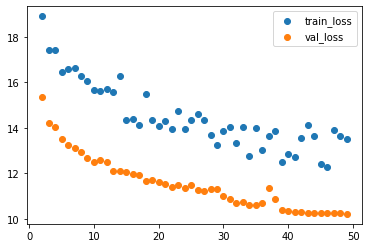

In [24]:
train_loss = history.dropna()['train_loss']
val_loss = history.dropna()['val_loss']
plt.scatter(train_loss.index[2:], train_loss[2:])
plt.scatter(val_loss.index[2:], val_loss[2:])
plt.legend(["train_loss", "val_loss"])

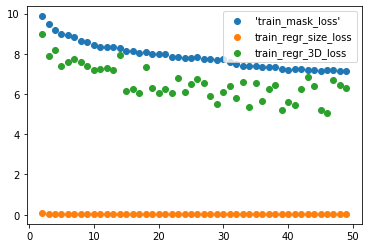

In [25]:
train_mask_loss = history.dropna()['train_mask_loss']
train_regr_size_loss = history.dropna()['train_regr_size_loss']
train_regr_3D_loss = history.dropna()['train_regr_3D_loss']
plt.scatter(train_loss.index[2:], train_mask_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_size_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_3D_loss[2:])
plt.legend(["'train_mask_loss'", "train_regr_size_loss", "train_regr_3D_loss"])

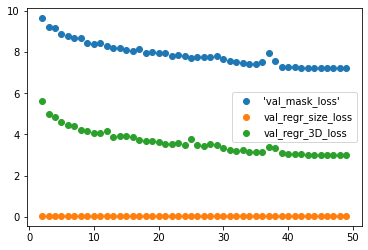

In [26]:
val_mask_loss = history.dropna()['val_mask_loss']
val_regr_size_loss = history.dropna()['val_regr_size_loss']
val_regr_3D_loss = history.dropna()['val_regr_3D_loss']
plt.scatter(val_loss.index[2:], val_mask_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_size_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_3D_loss[2:])
plt.legend(["'val_mask_loss'", "val_regr_size_loss", "val_regr_3D_loss"])

In [27]:
torch.cuda.empty_cache()
gc.collect()

0

# Check result

In [28]:
m = MyUNet(26)
m.eval()
m_state_dict = torch.load("../models/model.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

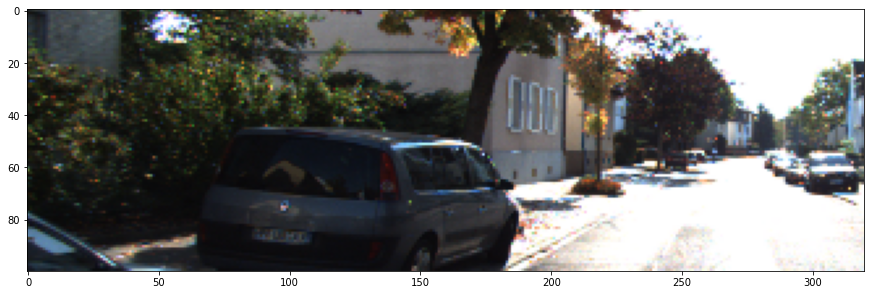

In [29]:
img, mask, regr, cnr, regr_cnr = val_dataset[0]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2)

In [30]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

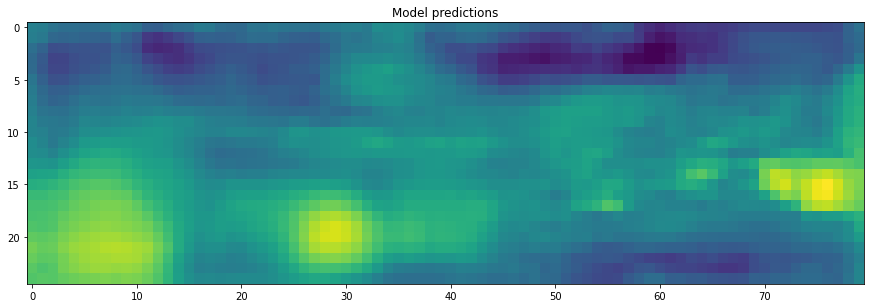

In [31]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

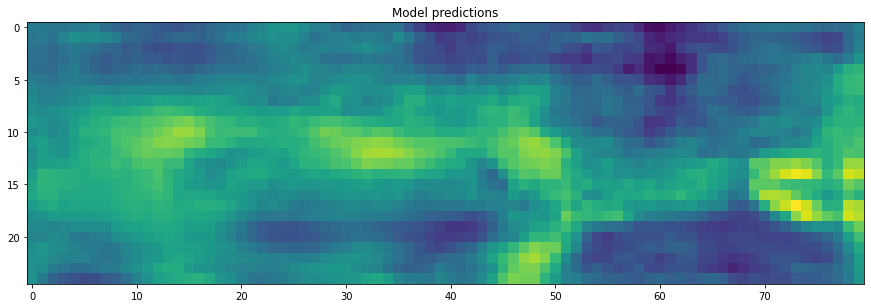

In [32]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

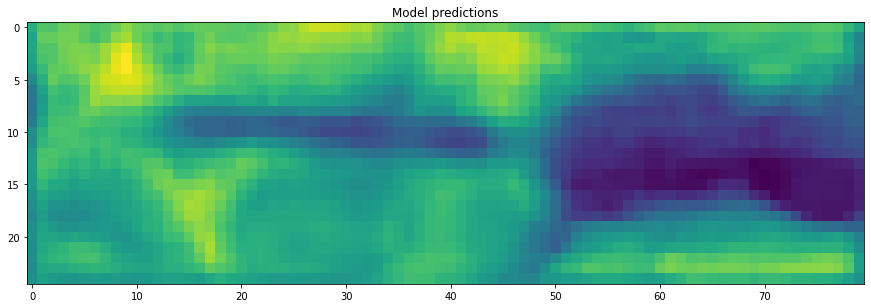

In [33]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,4].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()